In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../Year 2010-2011.csv
../README.md
../online_retail_II.xlsx
../Year 2009-2010.csv
../gold/rfm-customer-segmentation-using-k-means.ipynb


# RFM - Customer Segmentation Using K-Means Clustering

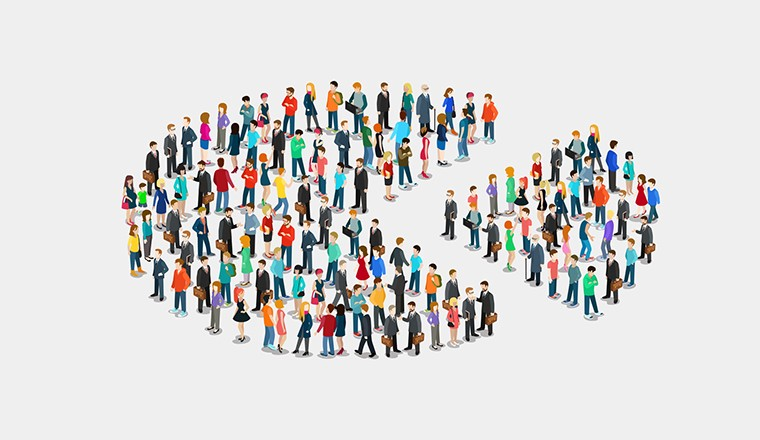

# Table of Content

1. [Import Library and Set Configurations](#section-one)  
2. [Load Dataset](#section-two)  
3. [Exploratory Data Analysis](#section-three) 
    * 3.1. [Country](#section-three-one)  
    * 3.2. [StockCode & Description](#section-three-two)  
    * 3.3. [Price & Quantity](#section-three-three)  
    * 3.4. [Total Price](#section-three-four)  
4. [RFM Metrics](#section-four)  
5. [K-Means](#section-five)  
    * 5.1. [Determining the Optimum Number of Clusters](#section-five-one)


    
    
    

<a id="section-one"></a>
## 1. Import Library and Set Configurations

In [40]:
import pandas as pd
import numpy as np
import datetime as dt

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [41]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


<a id="section-two"></a>
## 2. Load Dataset

In [42]:
df_ = pd.read_excel("../online_retail_II.xlsx", 
                    sheet_name="Year 2009-2010", engine='openpyxl') 
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95000,13085.00000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10000,13085.00000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25000,13085.00000,United Kingdom


<a id="section-three"></a>
## 3. Exploratory Data Analysis 

In [43]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(5))
    print("##################### Tail #####################")
    print(dataframe.tail(5))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

at first glance:
* Customer ID is duplicated
* null values in Description and Customer ID variables
* Customer ID's will be used for identifying customers on customer segmentation, so null values is both variables will be dropped.
* Price and Quantity variables have values below zero, which is not possible.
* Prices range from 0 to 25111

In [44]:
# drop null values

df.dropna(inplace=True)

In [45]:
# check one randomly picked customer's shopping history

df.loc[df['Customer ID'] == 13085.00000]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95000,13085.00000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10000,13085.00000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25000,13085.00000,United Kingdom
...,...,...,...,...,...,...,...,...
74409,496166,79323W,WHITE CHERRY LIGHTS,8,2010-01-29 11:42:00,6.75000,13085.00000,United Kingdom
74410,496166,21137,BLACK RECORD COVER FRAME,8,2010-01-29 11:42:00,3.75000,13085.00000,United Kingdom
74411,496166,22041,"RECORD FRAME 7"" SINGLE SIZE",6,2010-01-29 11:42:00,2.55000,13085.00000,United Kingdom
74412,496166,40046A,RED DAISY PAPER LAMPSHADE,12,2010-01-29 11:42:00,1.25000,13085.00000,United Kingdom


When a customer makes a purchase, the Invoice is duplicated and each unique item that has been purchased are transformed into seperate observations.

In [46]:
# number of unique customers

df['Customer ID'].nunique()

4383

<a id="section-three-one"></a>
### 3.1. Country

In [47]:
# which countries are the customers from

df['Country'].value_counts()

Country
United Kingdom          379423
EIRE                      8710
Germany                   8129
France                    5710
Netherlands               2769
Spain                     1278
Switzerland               1187
Belgium                   1054
Portugal                  1024
Channel Islands            906
Sweden                     883
Italy                      731
Australia                  654
Cyprus                     554
Austria                    537
Greece                     517
Denmark                    428
Norway                     369
Finland                    354
United Arab Emirates       318
Unspecified                280
USA                        244
Japan                      224
Poland                     194
Malta                      172
Lithuania                  154
Singapore                  117
Canada                      77
Thailand                    76
Israel                      74
Iceland                     71
RSA                         65


In [48]:
# customers without country information

df.loc[df['Country'] == "Unspecified", "Customer ID"].value_counts()


Customer ID
16320.00000    187
14265.00000     48
12470.00000     23
12351.00000     21
15357.00000      1
Name: count, dtype: int64

In [49]:
missing_country = [16320.00000,14265.00000,12470.00000,12351.00000,15357.00000]

df.loc[df['Customer ID'].isin(missing_country)].head(5)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
61394,494860,84832,ZINC WILLIE WINKIE CANDLE STICK,5,2010-01-19 11:01:00,0.85000,12470.00000,Unspecified
61395,494860,84836,ZINC METAL HEART DECORATION,5,2010-01-19 11:01:00,1.25000,12470.00000,Unspecified
61396,494860,85014D,PINK/BROWN DOTS RUFFLED UMBRELLA,1,2010-01-19 11:01:00,5.95000,12470.00000,Unspecified
61397,494860,85014A,BLACK/BLUE DOTS RUFFLED UMBRELLA,1,2010-01-19 11:01:00,5.95000,12470.00000,Unspecified
61398,494860,85014B,RED/WHITE DOTS RUFFLED UMBRELLA,2,2010-01-19 11:01:00,5.95000,12470.00000,Unspecified


5 customers' Country variables are empty, we won't be using Country information for segmentation so we'll leave them as is.

<a id="section-three-two"></a>
### 3.2. StockCode & Description

In [50]:
#do each StockCode belong to a specific Item

df.groupby('StockCode').agg({'Description': "nunique"}).sort_values(by='Description', ascending=False).head()

,Description
StockCode,
22345,4
22346,4
22384,4
20685,4
21955,4


In [51]:
df.loc[df['StockCode'] == 22384, 'Description'].unique()

array(['LUNCHBAG PINK RETROSPOT', 'LUNCH BAG PINK RETROSPOT',
       'LUNCH BAG PINK POLKADOT', 'LUNCH BAG PINK POLKADOTS'],
      dtype=object)

As an example, 4 item names above refer to the same item and StockCode. This duplicate may be due to manuel entry. StockCode is a better variable to analyze items.

<a id="section-three-three"></a>
### 3.3. Price & Quantity

In [52]:
# check the observations that have negative value for Quantity 

df.loc[df['Quantity'] < 0].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95000,16321.00000,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65000,16321.00000,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25000,16321.00000,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10000,16321.00000,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95000,16321.00000,Australia
183,C489449,21871,SAVE THE PLANET MUG,-12,2009-12-01 10:33:00,1.25000,16321.00000,Australia
184,C489449,84946,ANTIQUE SILVER TEA GLASS ETCHED,-12,2009-12-01 10:33:00,1.25000,16321.00000,Australia
185,C489449,84970S,HANGING HEART ZINC T-LIGHT HOLDER,-24,2009-12-01 10:33:00,0.85000,16321.00000,Australia
186,C489449,22090,PAPER BUNTING RETRO SPOTS,-12,2009-12-01 10:33:00,2.95000,16321.00000,Australia
196,C489459,90200A,PURPLE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25000,17592.00000,United Kingdom


In [53]:
# check the Invoices that starts with the letter "C"

df.loc[df['Invoice'].str.startswith("C",na=False), ["Quantity","Price"]].describe()

,Quantity,Price
count,9839.00000,9839.00000
mean,-21.54538,28.47438
std,212.07766,405.04159
min,-9360.00000,0.01000
25%,-6.00000,1.62500
50%,-2.00000,2.95000
75%,-1.00000,6.75000
max,-1.00000,25111.09000


Invoices that start with "C" are refunds, the Quantity values are below 0.

In [54]:
# get rid of refund invoices

df = df[~df["Invoice"].str.contains("C", na=False)]

In [55]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,407695.00000,13.58669,1.00000,2.00000,5.00000,12.00000,19152.00000,96.84223
InvoiceDate,407695,2010-07-01 10:10:10.782177792,2009-12-01 07:45:00,2010-03-26 14:01:00,2010-07-09 15:46:00,2010-10-14 17:09:00,2010-12-09 20:01:00,NaN
Price,407695.00000,3.29419,0.00000,1.25000,1.95000,3.75000,10953.50000,34.75666
Customer ID,407695.00000,15368.50411,12346.00000,13997.00000,15321.00000,16812.00000,18287.00000,1679.79570


<a id="section-three-four"></a>
### 3.4. Total Price

In [56]:
# derive a new variable by multiplying the price per unit with Quantity

df['TotalPrice'] = df['Quantity'] * df['Price']

In [57]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95000,13085.00000,United Kingdom,83.40000
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom,81.00000
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom,81.00000
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10000,13085.00000,United Kingdom,100.80000
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25000,13085.00000,United Kingdom,30.00000


<a id="section-four"></a>
## 4. RFM Metrics 

* **Recency** shows how recent the customer has purchased. So that is the duration between today and the last date that the customer has purchased. Today will be the last date within the dataset.  
* **Frequency** shows how frequent the customer purchases. So the number of unique Invoices will be the number of times that he/she purchased.
* **Monetary** shows the total amount of money that the customer has spent.


In [58]:
today_date = df['InvoiceDate'].max() + dt.timedelta(days=2)

In [59]:
# 2 days will be added to "today's date" to eliminate the local time differences between stores and to make sure
# that Recency is always above 0

today_date = df['InvoiceDate'].max() + dt.timedelta(days=2)
today_date

Timestamp('2010-12-11 20:01:00')

In [60]:
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                    'Invoice': lambda inv: inv.nunique(),
                                    'TotalPrice': lambda price: price.sum()})

In [61]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [62]:
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.00000,166,11,372.86000
12347.00000,4,2,1323.32000
12348.00000,75,1,222.16000
12349.00000,44,3,2671.14000
12351.00000,12,1,300.93000


In [63]:
check_df(rfm)

##################### Shape #####################
(4314, 3)
##################### Types #####################
Recency        int64
Frequency      int64
Monetary     float64
dtype: object
##################### Head #####################
             Recency  Frequency   Monetary
Customer ID                               
12346.00000      166         11  372.86000
12347.00000        4          2 1323.32000
12348.00000       75          1  222.16000
12349.00000       44          3 2671.14000
12351.00000       12          1  300.93000
##################### Tail #####################
             Recency  Frequency   Monetary
Customer ID                               
18283.00000       19          6  641.77000
18284.00000       68          1  461.68000
18285.00000      297          1  427.00000
18286.00000      113          2 1296.43000
18287.00000       19          4 2345.71000
##################### NA #####################
Recency      0
Frequency    0
Monetary     0
dtype: int64
########

no negative values, no null values

<a id="section-five"></a>
##  5.K-Means

* Instead of using a pre-defined number of clusters, the customers will be segmented according to their purchasing behaviours.  
* The logic behind K-Means is to cluster every observation with regards to their similarities using Sum of Squared Distances (SSD).

In [64]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

sc = MinMaxScaler((0, 1))
df = sc.fit_transform(rfm)

Monetary values range from 0 to 349164 whereas Recency and Frequency values range form 1 to a 3 digit number. By using MinMaxScaler, all the values are ranging from 0 to 1 (its default parameter). 

In [65]:
df[0:5]

array([[0.43967828, 0.04901961, 0.00106786],
       [0.00536193, 0.00490196, 0.00378996],
       [0.19571046, 0.        , 0.00063626],
       [0.11260054, 0.00980392, 0.00765009],
       [0.02680965, 0.        , 0.00086186]])

In [66]:
# a random number of cluster is being given as a parameter

kmeans = KMeans(n_clusters=4)
k_fit = kmeans.fit(df)

In [67]:
# centeroids for the 4 clusters

k_fit.cluster_centers_

array([[0.82035182, 0.00167699, 0.00150872],
       [0.20722256, 0.01036087, 0.00353839],
       [0.05025864, 0.02771576, 0.00933107],
       [0.50420705, 0.00519608, 0.00207937]])

<a id="section-five-one"></a>
### 5.1. Determining the Optimum Number of Clusters

Elbow Method will be used to determine the optimum number of clusters for rfm dataframe

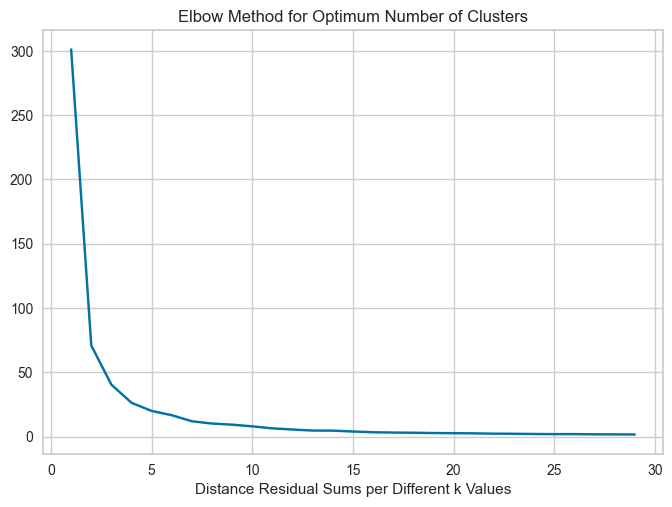

In [68]:
import matplotlib.pyplot as plt
# number of clusters between range(1,30) will be given as parameters within KMeans object

kmeans = KMeans()
ssd = []
K = range(1, 30)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(df)
    ssd.append(kmeans.inertia_)
    
plt.plot(K, ssd, "bx-")
plt.xlabel("Distance Residual Sums per Different k Values")
plt.title("Elbow Method for Optimum Number of Clusters")
plt.show()

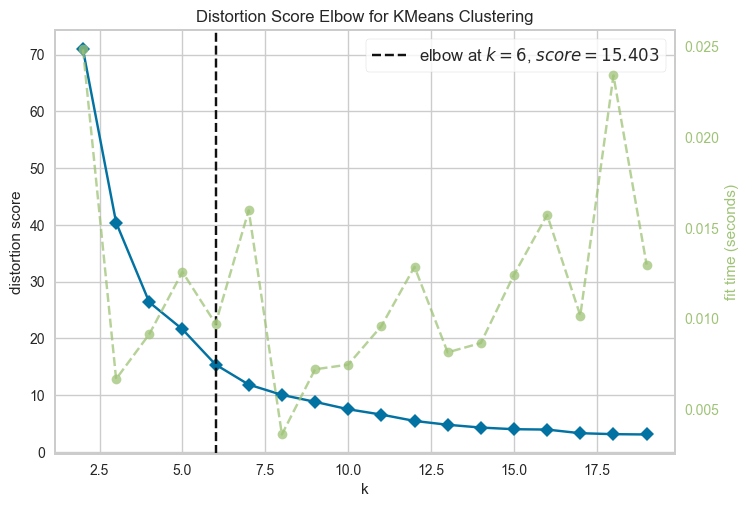

In [69]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans()
visu = KElbowVisualizer(kmeans, k=(2, 20))
visu.fit(df)
visu.show();

According to Elbow Method, the optimum number of cluster is 6.

In [88]:
kmeans = KMeans(n_clusters= 6, init= 'k-means++', max_iter= 1000)
kmeans.fit(df)
clusters = kmeans.labels_

df = pd.DataFrame(df)
df_clustered = df.copy()
df_clustered['Cluster'] = clusters.astype(int)
print("Dataframe with cluster column:", df_clustered.head())
header = list(df.columns) + ['Cluster']
df_clustered.to_csv('cluster.csv', index=False, header=header)
print("Clustered data saved to cluster.csv")


(4314,)
(4314, 3)


AttributeError: 'numpy.ndarray' object has no attribute 'head'

* ‘k-means++’ parameter selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.  
* 'max_iter' parameter for the maximum number of iterations of the k-means algorithm for a single run. It is given in order to avoid an endless loop.

In [71]:
# segment labels for the first 30 customers

clusters[0:30]

array([4, 2, 0, 0, 2, 2, 0, 1, 2, 2, 2, 0, 2, 0, 3, 1, 1, 0, 1, 0, 1, 0,
       2, 2, 1, 0, 0, 2, 2, 0], dtype=int32)

In [ ]:
# customer id's and the segment numbers

pd.DataFrame({"Customer ID": rfm.index, "Clusters": clusters})

,Customer ID,Clusters
0,12346.00000,2
1,12347.00000,0
2,12348.00000,4
3,12349.00000,4
4,12351.00000,0
...,...,...
4309,18283.00000,0
4310,18284.00000,4
4311,18285.00000,3
4312,18286.00000,2


In [ ]:
# add cluster numbers as a variable to rfm dataframe
# add 1 to cluster segment number so that it starts with 1

rfm["Cluster"] = clusters
rfm["Cluster"] = rfm["Cluster"] + 1

In [ ]:
rfm.head(15)

,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.00000,166,11,372.86000,3
12347.00000,4,2,1323.32000,1
12348.00000,75,1,222.16000,5
12349.00000,44,3,2671.14000,5
12351.00000,12,1,300.93000,1
12352.00000,12,2,343.80000,1
12353.00000,45,1,317.76000,5
12355.00000,204,1,488.21000,2
12356.00000,17,3,3562.25000,1
